# Anomaly Detection

When to use anomaly detection vs. when to use supervised learning:

- **Anomaly detection:**
    - Very few positive examples (y = 1) (0-20 is common), with a large number of negative examples (y = 0).
    - If there are many different "types" of anomalies. It's challenging for any algorithm to learn from positive examples what the anomalies look like; future anomalies may bear no resemblance to any of the anomalous examples encountered thus far.
    - Examples: 
        - Fraud detection.
        - Manufacturing: finding new previously unseen defects in manufacturing.
        - Monitoring machines in a data center (different types of attacks or malfunctions).

- **Supervised learning:**
    - Large number of positive and negative examples.
    - Sufficient positive examples for the algorithm to grasp what positive examples entail; future positive examples are likely to resemble those in the training set.
    - Examples: 
        - Email spam classification.
        - Manufacturing: finding known previously seen defects.
        - Weather prediction (sunny/rainy/etc.).
        - Diseases classification.


## Librarys

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
from mpl_toolkits.mplot3d import Axes3D

random.seed(99999)

## Dataset

In [66]:
df = pd.read_csv("data\climate change\GlobalLandTemperaturesByCountry.csv")
print(df.columns)
df.head()

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [67]:
x_train = df[['dt', 'AverageTemperature', 'Country']]

x_train_brazil = x_train['Country'] == 'Brazil'
x_train = x_train[x_train_brazil]
x_train.dropna(inplace=True)
x_train['dt'] = pd.to_datetime(x_train['dt'])
x_train['Month'] = x_train['dt'].dt.month

sample_rows = x_train.sample(n=10)
sample_rows

,dt,AverageTemperature,Country,Month
77387,1855-02-01,25.430,Brazil,2
78495,1947-06-01,23.942,Brazil,6
78572,1953-11-01,25.849,Brazil,11
77994,1905-09-01,25.159,Brazil,9
78870,1978-09-01,25.245,Brazil,9
78269,1928-08-01,23.705,Brazil,8
77474,1862-05-01,24.010,Brazil,5
78793,1972-04-01,24.311,Brazil,4
78857,1977-08-01,24.984,Brazil,8
77771,1887-02-01,24.502,Brazil,2


In [68]:
x_train = x_train[['AverageTemperature', 'Month']]
x_train.head()

,AverageTemperature,Month
77110,24.935,1
77111,24.505,2
77112,24.617,3
77113,23.990,4
77114,23.124,5


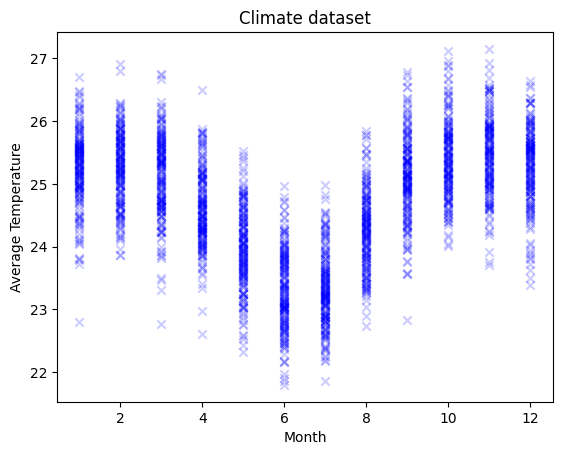

In [69]:
plt.scatter(x_train['Month'], x_train['AverageTemperature'], marker='x', c='b', alpha=0.2) 
plt.title("Climate dataset")
plt.ylabel('Average Temperature')
plt.xlabel('Month')
plt.show()

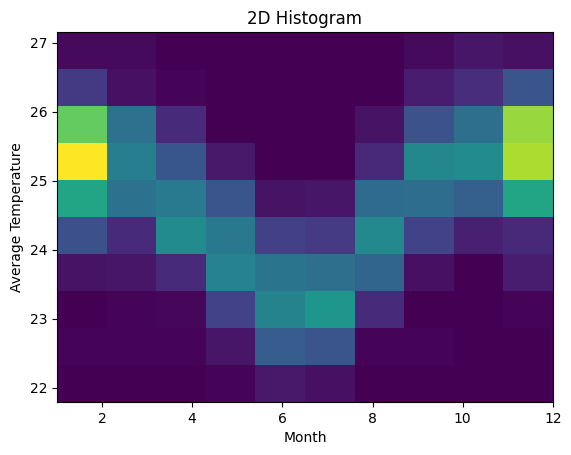

In [70]:
plt.hist2d(x_train['Month'], x_train['AverageTemperature'])
plt.title("2D Histogram")
plt.ylabel('Average Temperature')
plt.xlabel('Month')
plt.show()

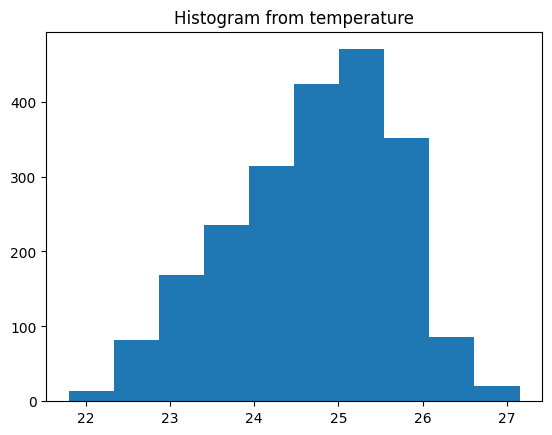

In [71]:
plt.hist(x_train['AverageTemperature'])
plt.title("Histogram from temperature")
plt.show()

## Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution. But first, we need the mean and the variance.

### Mean and variance

To estimate the parameters ($\mu_i$, $\sigma_i^2$) of the $i$-th
feature, we will be using the following equations:

- Mean:
    $$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

- Variance:
    $$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [72]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    mu = np.sum(X, axis=0) / m
    var = np.sum((X - mu) ** 2, axis=0) / m
    
    return mu, var

### Probability Model

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each of the features $x_i$. 

* The Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

In [73]:
def multivariate_gaussian(X, mu, var):
    n = len(mu)
    constant = 1 / ((2 * np.pi) ** (n / 2) * np.sqrt(np.prod(var)))
    exponent = -0.5 * np.sum(((X - mu) ** 2) / var, axis=1)
    p = constant * np.exp(exponent)
    
    return p

In [74]:
mu, var = estimate_gaussian(x_train)
print(mu)
print(var)

AverageTemperature    24.699256
Month                  6.486137
dtype: float64
AverageTemperature     0.957582
Month                 11.899531
dtype: float64


In [75]:
# Probabilities
p_train = multivariate_gaussian(x_train, mu, var)

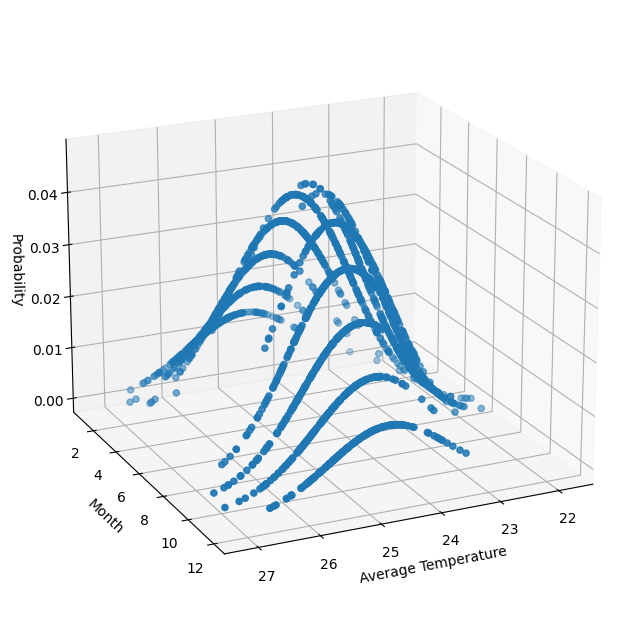

In [76]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotando a dispersão em 3D
ax.scatter(x_train['AverageTemperature'], x_train['Month'], p_train)

ax.set_xlabel('Average Temperature')
ax.set_ylabel('Month')
ax.set_zlabel('Probability')
ax.view_init(elev=20, azim=65)  # Ajuste conforme necessário

plt.show()

### Selecting the threshold $\epsilon$

Now it is possible to investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

To implement code to calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`. 

  * Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, you can compute precision and recall by: 
      
    $$
    \begin{aligned}
    precision &=& \frac{tp}{tp+fp}\\
    reccall &=& \frac{tp}{tp+fn}
    \end{aligned}
    $$ 
    
    where:
      * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
      * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
      * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In [77]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    epsilons = np.arange(min(p_val), max(p_val), step_size)

    for epsilon in epsilons:
        predictions = (p_val < epsilon)
        
        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))
        
        prec = tp / (tp + fp)        
        rec = tp / (tp + fn)
        F1 = 2 * prec * rec / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

Creating "new" data for validation dataset to detect anomalies. The idea is that based on each month we will generate data larger than the min and max temperature for that month, and normal data for temperatures between the min and max.

In [78]:
# Anomaly data
size_val_anomalous = 20

max_temp_by_month = x_train.groupby('Month')['AverageTemperature'].max()
min_temp_by_month = x_train.groupby('Month')['AverageTemperature'].min()

x_val_anomalous = []
for _ in range(size_val_anomalous//2):
    month = random.randint(1, 12)
    temp = random.uniform(max_temp_by_month[month], max_temp_by_month[month] + 10)
    x_val_anomalous.append({'Month': month, 'AverageTemperature': temp})

    month = random.randint(1, 12)
    temp = random.uniform(min_temp_by_month[month] - 10, min_temp_by_month[month])
    x_val_anomalous.append({'Month': month, 'AverageTemperature': temp})

y_val_anomalous = [1] * size_val_anomalous

# Non anomaly data
size_val_non_anomalous = 20

x_val_non_anomalous = []
for _ in range(size_val_non_anomalous):
    month = random.randint(1, 12)
    temp = random.uniform(min_temp_by_month[month], max_temp_by_month[month])
    x_val_non_anomalous.append({'Month': month, 'AverageTemperature': temp})

y_val_non_anomalous = [0] * size_val_non_anomalous

# Converting to DataFrames
x_val_anomalous = pd.DataFrame(x_val_anomalous)
x_val_non_anomalous = pd.DataFrame(x_val_non_anomalous)

x_val = pd.concat([x_val_anomalous, x_val_non_anomalous], ignore_index=True)
y_val = y_val_anomalous + y_val_non_anomalous

x_val.sample(n=10)

,Month,AverageTemperature
9,5,17.396421
6,4,27.103635
10,12,33.333257
30,10,26.299079
23,10,24.045018
13,2,21.651739
28,5,25.006818
14,3,28.015169
27,10,26.029843
32,1,25.789703


In [79]:
p_val = multivariate_gaussian(x_val, mu, var)
epsilon, F1 = select_threshold(np.array(y_val), p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)


C:\Users\Ivon\AppData\Local\Temp\ipykernel_5088\3054085109.py:30: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)


Best epsilon found using cross-validation: 2.126749e-03
Best F1 on Cross Validation Set: 0.926829


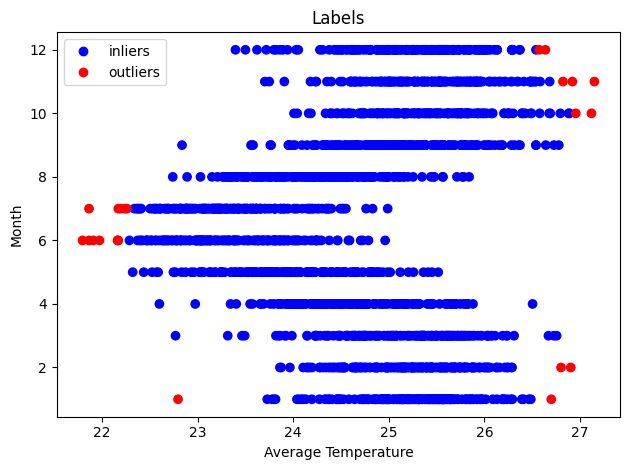

In [80]:
colors = ListedColormap(['blue', 'red'])
classes = ['inliers','outliers']

outliers = p_train < epsilon

fig = plt.figure()  # Corrigindo para 'fig'
ax = fig.add_subplot(111)  # Definindo o subplot

data = np.array(x_train)
scatter1 = ax.scatter(data[:,0], data[:,1], c=outliers, cmap=colors)
ax.set_title("Labels")
ax.set_xlabel('Average Temperature')
ax.set_ylabel('Month')
ax.legend(handles=scatter1.legend_elements()[0], labels=classes)

plt.tight_layout()
plt.show()
